In [2]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=41d233d1ee5e0d01a5e8d70d405a774863d2ad8016af3b03607d48342b40e55f
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import numpy as np
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
print("Running TensorFlow version ",tf.__version__)

Running TensorFlow version  2.2.0


In [0]:
def yahoo_finance(start, end, ticker):
    column_names = ["Open", "High", "Low",'Close','Volume', 'Dividends', 'Stock Splits']
    df = pd.DataFrame(columns = column_names)
    stock = yf.Ticker(ticker).history(period='1d', start = start, end = end)
    train = pd.concat([df,stock])
    
    return train

In [0]:
train = yahoo_finance('2000-01-01', '2018-12-31', 'AAPL')

In [0]:
test_temp = yahoo_finance('2018-11-30', '2020-05-30', 'GOOG')

In [0]:
def f1(group):
    return pd.DataFrame({'rolling_count' : group.cumsum()})

def feature_engineering(df):
    df['return'] = round(df.Close.pct_change(),3)
    df['r_prev_open'] = round((df['Open']-df['Close'].shift(1))/df['Close'].shift(1),3)
    df['past_week_vol'] = round(df['Close'].pct_change().rolling(5).std(),3)
    df["past_week_ma"] = round(df["return"].rolling(5).mean(),3)
    df['direction'] = df['return'].map(lambda x: 0 if x == 0 else x/abs(x))
    df['dir_change'] = (df.direction.shift(1) != df.direction).astype(int)
    df['block'] = df.dir_change.cumsum()
    grouped = df.groupby('block')
    df['one'] = 1
    df['dir_change_count'] = grouped['return'].apply(f1)
    df['dir_change_count'] = grouped.one.apply(f1)
    df = df.drop(['one', 'block'],  axis=1)
    df["return_bucket"] = 0 
    df.loc[df['return']>=0.01,"return_bucket"] = 1 
    df.loc[df['return']<=-0.01,"return_bucket"] = -1 
    df['return_daily'] = (df['Close']-df['Open'])/df['Open']
    df['past_week_vol_o'] = round(df['Open'].pct_change().rolling(5).std(),3)
    df["past_week_ma_d"] = round(df["return_daily"].rolling(5).mean(),3)
    df['direction_d'] = df['return_daily'].map(lambda x: 0 if x == 0 else x/abs(x))
    df['dir_change_d'] = (df.direction_d.shift(1) != df.direction_d).astype(int)
    df['block_d'] = df.dir_change_d.cumsum()
    grouped_d = df.groupby('block_d')
    df['one_d'] = 1
    df['dir_change_count_d'] = grouped_d['return_daily'].apply(f1)
    df['dir_change_count_d'] = grouped_d.one_d.apply(f1)
    df = df.drop(['one_d', 'block_d'],  axis=1)
    df["return_bucket_d"] = 0 
    df.loc[df['return_daily']>=0.01,"return_bucket_d"] = 1 
    df.loc[df['return_daily']<=-0.01,"return_bucket_d"] = -1 
    df = df.dropna()
    
    return df

In [0]:
#train = feature_engineering(train)
test_temp = feature_engineering(test_temp)

In [0]:
test = test_temp.loc['2019-01-02':,]

In [152]:
train

,Open,High,Low,Close,Volume,Dividends,Stock Splits,return,r_prev_open,past_week_vol,past_week_ma,direction,dir_change,dir_change_count,return_bucket,return_daily,past_week_vol_o,past_week_ma_d,direction_d,dir_change_d,dir_change_count_d,return_bucket_d
2000-01-10,3.15,3.16,2.93,3.02,126266000,0.0,0.0,-0.019,0.023,0.060,-0.025,-1.0,1,1,-1,-0.041270,0.061,-0.032,-1.0,1,1,-1
2000-01-11,2.97,3.07,2.80,2.87,110387200,0.0,0.0,-0.050,-0.017,0.053,-0.018,-1.0,0,2,-1,-0.033670,0.060,-0.028,-1.0,0,2,-1
2000-01-12,2.94,2.95,2.67,2.70,244017200,0.0,0.0,-0.059,0.024,0.051,-0.033,-1.0,0,3,-1,-0.081633,0.060,-0.045,-1.0,0,3,-1
2000-01-13,2.92,3.05,2.86,2.99,258171200,0.0,0.0,0.107,0.081,0.071,0.005,1.0,1,1,1,0.023973,0.056,-0.020,1.0,1,1,1
2000-01-14,3.09,3.16,3.07,3.11,97594000,0.0,0.0,0.040,0.033,0.070,0.004,1.0,0,2,1,0.006472,0.049,-0.025,1.0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,153.76,155.03,146.67,147.75,95744600,0.0,0.0,-0.039,0.000,0.021,-0.018,-1.0,0,3,-1,-0.039087,0.016,-0.019,-1.0,0,3,-1
2018-12-24,145.22,148.55,143.69,143.92,37169200,0.0,0.0,-0.026,-0.017,0.020,-0.022,-1.0,0,4,-1,-0.008952,0.024,-0.019,-1.0,0,4,0
2018-12-26,145.37,154.12,143.82,154.06,58582500,0.0,0.0,0.070,0.010,0.045,-0.010,1.0,1,1,1,0.059778,0.025,-0.008,1.0,1,1,1
2018-12-27,152.76,153.67,147.10,153.06,53117100,0.0,0.0,-0.006,-0.008,0.044,-0.005,-1.0,1,1,0,0.001964,0.041,-0.002,1.0,0,2,0


In [153]:
train.iloc[0,15]

-0.041269841269841234

In [0]:
import sklearn.preprocessing as prep
sc = prep.StandardScaler()

def create_X_y(data, M):
    X = []
    y = []

    for i in range(0, data.shape[0] - M):
        X.append(sc.fit_transform(data.iloc[i : i+M, ].values))
        y.append(data.iloc[i+M,15])
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y

M = 10

In [0]:
#X_train, y_train = create_X_y(train,M)
X_test, y_test = create_X_y(test,M)

In [0]:
stocks = np.array(['MA', 'GOOG', 'MSFT', 'FB', 'ADBE'])

X_train2 = X_train.copy()
y_train2 = y_train.copy()

for i in stocks:
    
    df_temp = yahoo_finance('2000-01-01', '2018-12-31', i)
    df_temp = feature_engineering(df_temp)
    x_temp, y_temp = create_X_y(df_temp,M)
    
    X_train2 = np.concatenate((X_train2, x_temp))
    y_train2 = np.concatenate((y_train2, y_temp))

In [158]:
print(X_train2.shape)
print(y_train2.shape)

(22695, 10, 22)
(22695,)


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
modelName = "class_model"

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0, patience=3, verbose=0, 
                                               mode='auto', baseline=None, restore_best_weights=True)
callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)]

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization, Flatten

def LSTM_model(X, y, units, batchsize, epoch, M):
    inputshape = (M, X.shape[2])
    drop_rate = 0.05
    val_split = 0.1
    units2 = int(units/2)
    units3 = int(units/4)
    
    lstm = Sequential()
    lstm.add(LSTM(units, input_shape=inputshape, activation='relu', return_sequences=True))
    lstm.add(LSTM(units2, input_shape=inputshape, activation='relu', return_sequences=True))
    lstm.add(LSTM(units3, input_shape=inputshape, activation='relu', return_sequences=True))
    lstm.add(LSTM(units, activation='relu'))
    lstm.add(Dropout(drop_rate))
    lstm.add(Dense(1))
    lstm.add(Activation('linear'))
    #lstm.add(BatchNormalization())
    print(lstm.summary())

    lstm.compile(optimizer='adam', loss="mean_squared_error")
    _=lstm.fit(X, y, batch_size = batchsize, epochs=epoch, validation_split=val_split, callbacks=callbacks)
    return lstm

In [217]:
# (x_train, y_train, unit, batchsize, epoch, longterm)
lstm1 = LSTM_model(X_train2, y_train2, 1024, 128, 50, M)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 10, 1024)          4288512   
_________________________________________________________________
lstm_53 (LSTM)               (None, 10, 512)           3147776   
_________________________________________________________________
lstm_54 (LSTM)               (None, 10, 256)           787456    
_________________________________________________________________
lstm_55 (LSTM)               (None, 1024)              5246976   
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1025      
_________________________________________________________________
activation_10 (Activation)   (None, 1)               

In [0]:
def plot(model):
    model_pred = model.predict(X_test)
    model_rmse = np.sqrt(np.mean(np.square(y_test - model_pred)))

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(test['return'].index[M:], test['return'][M:], label='truth')
    ax.plot(test['return'].index[M:], model_pred, linestyle='--',
            label="forecast (RMSE={:0.4f})".format(model_rmse))
    ax.legend()
    ax.set_title("LSTM")
    _=plt.show()

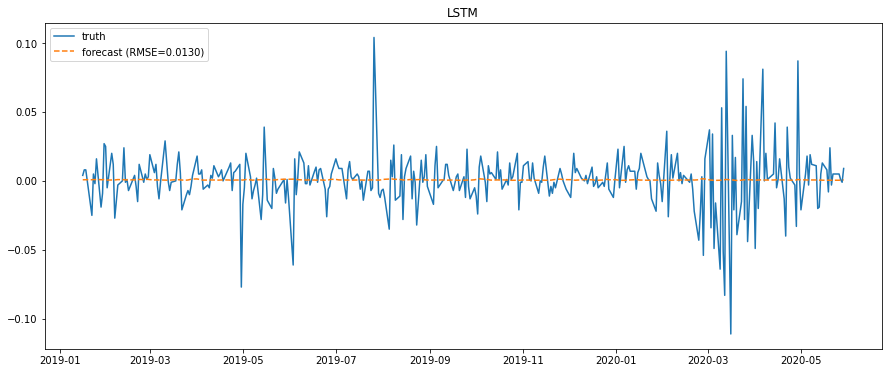

In [249]:
plot(lstm1)

In [0]:
import sklearn.metrics as mc

def prediction(model):
    model_pred = model.predict(X_test)
    pred = pd.DataFrame(data=model_pred, index=test.iloc[M:,].index, columns=["pred"])
    pred['actual'] = y_test
    pred['pred_direction'] = 1
    pred.loc[pred['pred']<0,"pred_direction"] = -1 
    pred['actual_direction'] = 1
    pred.loc[pred['actual']<0,"actual_direction"] = -1 

    acc = round(mc.accuracy_score(pred['actual_direction'], pred['pred_direction']),4)
    return pred, acc

In [250]:
lstm1_pred,lstm1_acc = prediction(lstm1)
print(lstm1_acc)

0.5478


In [220]:
lstm1_pred['actual_direction'].value_counts(normalize=True) * 100

 1    56.811594
-1    43.188406
Name: actual_direction, dtype: float64

In [0]:
def backtest(df):
    df['signal'] = 0
    df['return_hold'] = test.iloc[M:,7]
    df['r_prev_open'] = test.iloc[M:,15]
    df.loc[(df['pred']>(0.0004)), 'signal'] = 1
    df.loc[(df['pred']<(0)), 'signal'] = -1
    df['strat return'] = df['actual']*df['signal']
    df['stock cumulative return'] = (df['return_hold']+1).cumprod()
    df['strat cumulative return'] = (df['strat return']+1).cumprod()
    Roll_Max = df['strat cumulative return'].cummax()
    Daily_Drawdown = df['strat cumulative return']/Roll_Max - 1.0
    df['maxDD']= Daily_Drawdown.cummin()

    volatility = df['strat return'].std() * np.sqrt(df.shape[0])
    sharpe_ratio = round((df['strat cumulative return'][-1]-1 - 0.02) / volatility,3)
    print('sharpe ratio:', sharpe_ratio)
    print('maxDD:', round(df['maxDD'][-1],3))

    fig, ax =plt.subplots(figsize=(15,5), dpi=250)
    df['strat cumulative return'].plot(ax=ax, label='strat cumulative return')
    plt.plot(df['stock cumulative return'], label='buy & hold', color='coral')
    plt.legend()
    plt.title('LSTM GOOG')
    ax.axvspan(*mdates.datestr2num(['04/28/2019', '06/06/2019']), color='gray', alpha=0.2)
    ax.axvspan(*mdates.datestr2num(['02/20/2020', '04/03/2020']), color='gray', alpha=0.2)
    ax.set_xlabel('')

sharpe ratio: 2.851
maxDD: -0.084


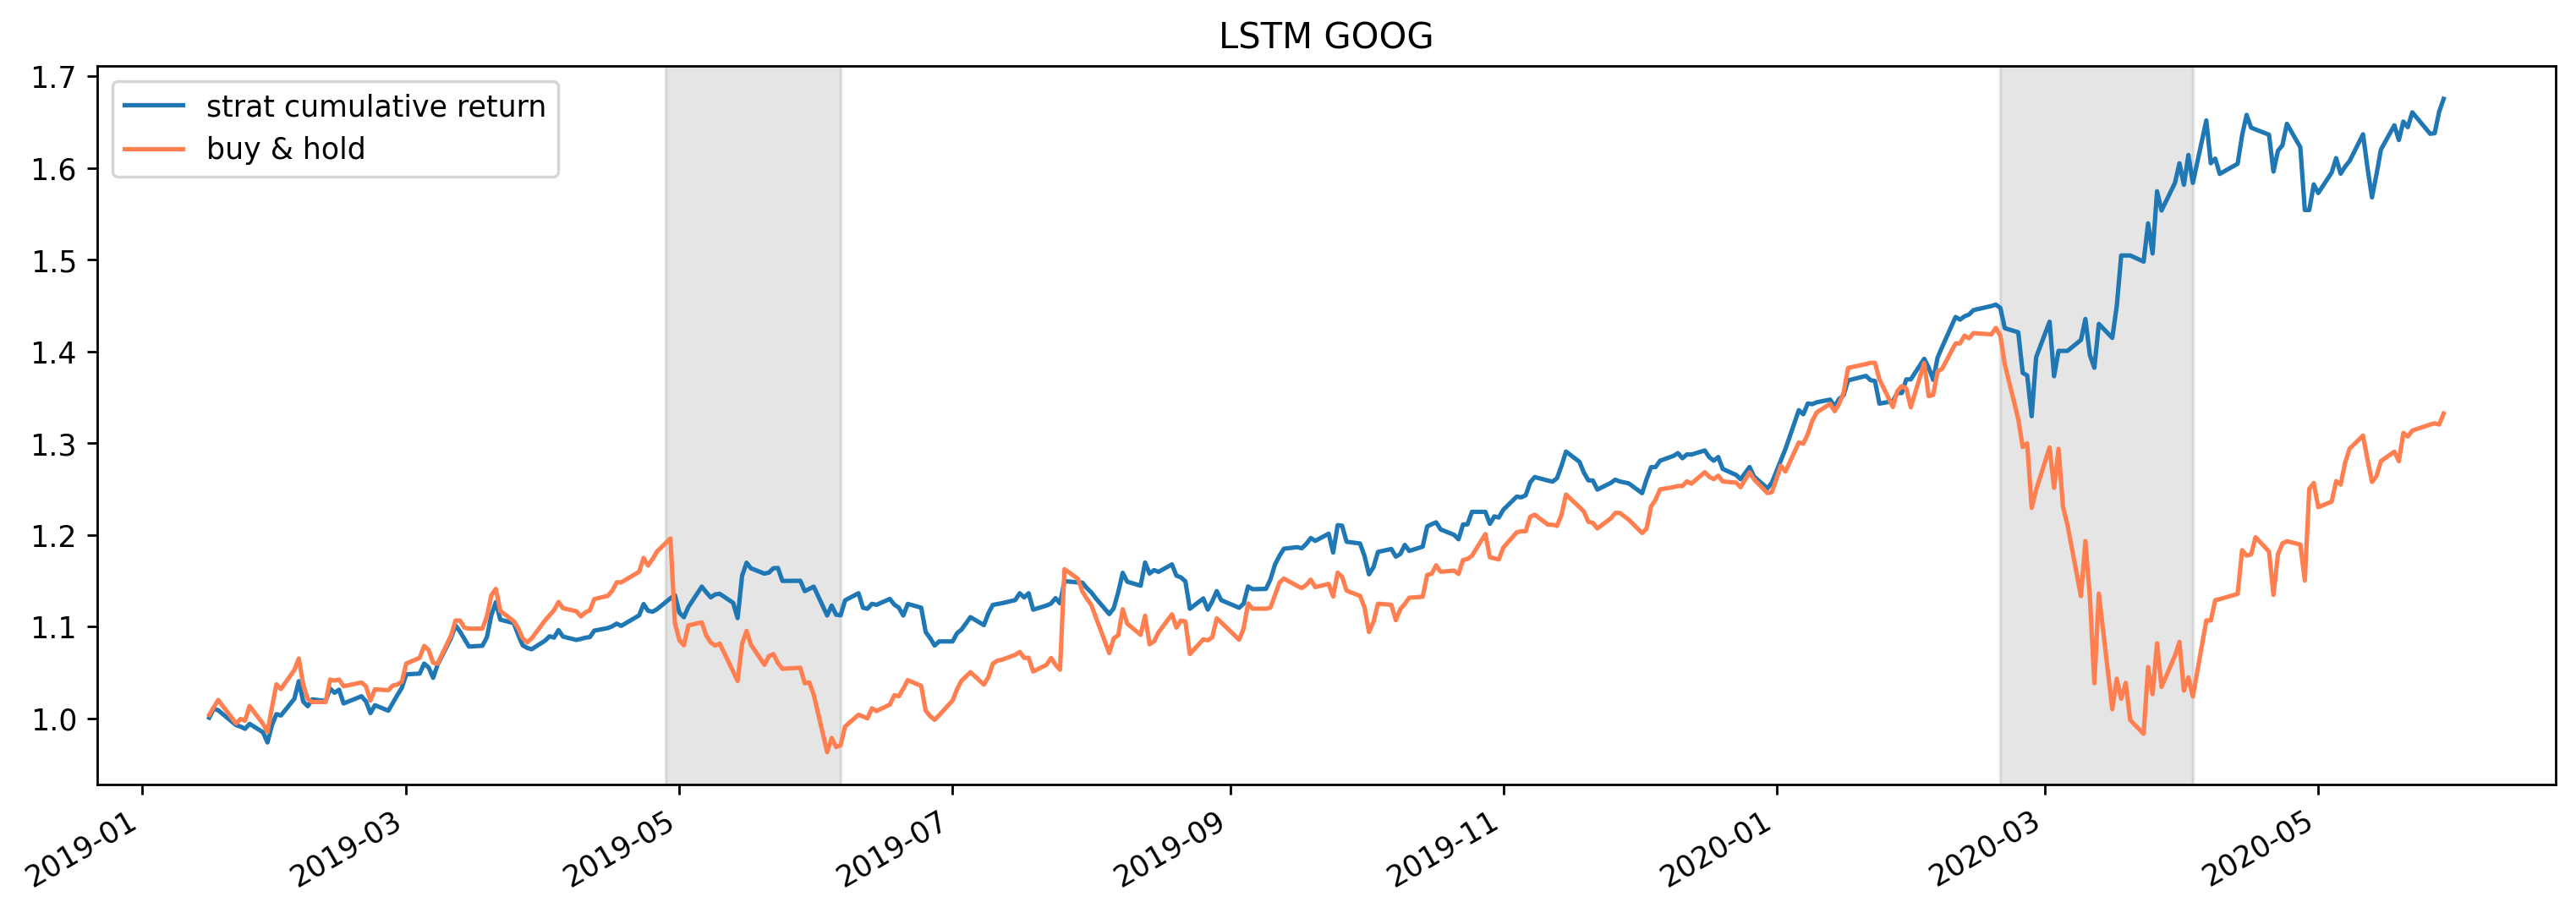

In [338]:
backtest(lstm1_pred)